<a href="https://colab.research.google.com/github/jjc16/Project_Notebooks/blob/master/Variational_Autoencoder_for_Image_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder for Image Embedding

This notebook demonstrates development of a fast prototype for ranking similar images in an input training set. 

## Background: 
Variational autoencoders expand traditional autoencoders by using a trained Linear layer to shape the latent space in a traditional autoencoder to have normally distributed values. It does this by 
  - training the Linear layer by taking the KL-divergence between the transformed latent space and a $N (0,1)$ distribution (where $N$ is the normal distribution) and 
  - sampling the reconstructed images from the latent space (assuming a normal distribution) and using the sampled images to calculate the reconstruction loss

## Novelties in notebook

This notebook also adds a classification head that inputs the latent space and outputs logits for each class in the dataset. The idea here is to not only identify close images (in the latent space) but also return the probable classes.

## References:

The author utilized several third-party sources to create this notebook:

- Data source: http://aws-proserve-data-science.s3.amazonaws.com/geological_similarity.zip 

- PyTorch Lightning Bolts: https://pytorch-lightning-bolts.readthedocs.io/

If you wish to use any code from this notebook in your project, please contact the author: j j c 1 6 [at] y a h o o . c o m. The author makes no warranty, express or implied, about the suitability of this code for any project.

We start by installing PyTorch Lighting Bolts:

In [1]:
# !pip install torch
!pip install lightning-bolts["extra"]

## Imports

We need to import the needed libraries

In [2]:
import torch
from pl_bolts.models.autoencoders import VAE
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
import torchvision
import pytorch_lightning as pl

device = 'cuda:0'

## Connect data storage location

Now, we connect the data, show a sample image, print the max and min values, and display the shape of the data

Picture Min value: 63
Picture Max value: 198
Picture Shape: (28, 28, 3)


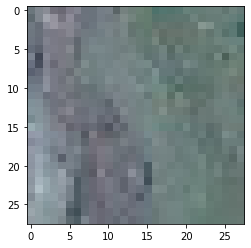

In [3]:
pth = '/content/drive/MyDrive/geo_sim/geological_similarity/andesite/01LQQ.jpg'
with Image.open(pth,'r') as im:
  data = np.asarray(im)
imshow(data)
print(f'Picture Min value: {np.min(data)}')
print(f'Picture Max value: {np.max(data)}')
print(f'Picture Shape: {data.shape}')

## Transforms

We will be using a Resnet18 model for the image encoder and decoder. To do this, our images need to be at least size 32 x 32. Also, we need to normalize the images (using values explained in the Resnet18 documentation) and turn the outputs into tensors for model ingestion. The results of doing this are below:

In [4]:
trans_norm = torchvision.transforms.Normalize((0.485, 0.456, 0.406), 
                                         (0.229, 0.224, 0.225))
trans_resize = torchvision.transforms.Resize(size=(32,32))
trans_ten = torchvision.transforms.ToTensor()
# trans_un = torchvision.transforms.Lambda(lambda x: torch.unsqueeze(x,0))
trans_comp = torchvision.transforms.Compose([trans_ten, trans_resize, trans_norm])
out = trans_comp(data)
print(out.shape)
print(data.shape)

torch.Size([3, 32, 32])
(28, 28, 3)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


## Model:

Now, we create a variational autoencoder model (VAE). We utilize PyTorch Lighting Bolts to skip writing boilerplate code and greatly accelerate our development

In [5]:
model = VAE(input_height=32)
print(model)


VAE(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

## Datasets and Dataloader:

We now create PyTorch Datasets and DataLoaders for the training, validation, and test data

In [6]:
ds = torchvision.datasets.ImageFolder('/content/drive/MyDrive/geo_sim/geological_similarity', transform=trans_comp)
from math import floor
tr_len = floor(0.8*len(ds))
val_ln = floor(0.1*len(ds))
tst_ln = len(ds) - tr_len - val_ln
train_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_ln, tst_ln])
print(len(train_ds), len(val_ds), len(test_ds))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64)

23999 2999 3001


## Custom VAE Model

The VAE model that is created by default doesn't have quite the features that we want. We also want to add a linear classification head to it to predict the classes of the encoded images. To do this, we create a custom model with a an extra linear layer and an overriden step function

In [7]:
class CustomVAE(VAE):
  def __init__(self, *args, num_classes=6, **kwargs):
    super().__init__(*args, **kwargs)
    self.classification_head = torch.nn.Linear(self.latent_dim, num_classes)

  def step(self, batch, batch_idx, alpha=0.1):
    loss, logs = super().step(batch, batch_idx)
    enc = self.encoder(batch[0])
    enc_mu = self.fc_mu(enc)
    x_cl = self.classification_head(enc_mu)
    labels = batch[1]
    # print(labels.shape)
    # print(x_cl.shape)
    loss_class = alpha*torch.nn.CrossEntropyLoss()(x_cl, labels)
    loss = loss + loss_class
    # if batch_idx % 10 ==0:
    #   print(batch_idx)
    return loss, logs


In [23]:
cust_model = CustomVAE(input_height=32)
cust_model.load_from_checkpoint('/content/drive/MyDrive/lightning_logs/lightning_logs/version_0/checkpoints/vae_model.ckpt')
# params = torch.load('/content/drive/MyDrive/lightning_logs/lightning_logs/version_0/checkpoints/vae_model.ckpt')
# model=pl.LightningModule.load_from_checkpoint('/content/drive/MyDrive/lightning_logs/lightning_logs/version_0/checkpoints/vae_model.ckpt')

CustomVAE(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

## PyTorch Lighting Bolts Trainer

Now, we create a trainer and use the .fit method to fit to our data

In [ ]:
# tr = pl.Trainer(gpus=1,progress_bar_refresh_rate=1, default_root_dir='/content/drive/MyDrive/lightning_logs/')
# tr.fit(cust_model, train_dataloader=train_dl, val_dataloaders=val_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type          | Params
------------------------------------------------------
0 | encoder             | ResNetEncoder | 11.2 M
1 | decoder             | ResNetDecoder | 8.6 M 
2 | fc_mu               | Linear        | 131 K 
3 | fc_var              | Linear        | 131 K 
4 | classification_head | Linear        | 1.5 K 
------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.235    Total estimated model params size (MB)


In [10]:
it = iter(train_dl)

In [11]:
tst = next(it)

In [49]:
def list_embeddings(model, ds):
  out = []
  for ii, val in enumerate(ds):
    if ii % 100 == 0:
      print(ii)
    enc = model.encoder(val[0].unsqueeze(0))
    enc_mu = cust_model.fc_mu(enc)
    out.append([enc_mu.detach().numpy(), val[0].detach().numpy()])

  return out

In [ ]:
emb = list_embeddings(cust_model, ds)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [44]:
for ii,val in enumerate(train_dl):
  print(ii)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


KeyboardInterrupt: ignored